绿色物流中心选址问题：某电商公司需在5个候选位置中选择建立物流中心，需考虑：

建设成本（不同位置成本不同）
覆盖人口（不同位置覆盖不同区域人口）
碳排放量（不同位置运输距离不同）
目标：在预算限制内，最大化覆盖人口，同时满足碳排放限制

决策变量：yᵢ = {0,1} 表示是否在位置i建物流中心

In [1]:
import pulp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Circle

In [2]:
# 1. 定义问题数据
# 候选位置信息
locations = ['A', 'B', 'C', 'D', 'E']
costs = [50, 70, 40, 60, 55]     # 建设成本(万元)
populations = [80, 100, 60, 90, 75]  # 覆盖人口(千人)
emissions = [12, 15, 8, 14, 10]    # 碳排放(吨/年)

# 问题参数
budget = 150  # 总预算(万元)
max_emission = 30  # 最大允许碳排放(吨/年)
min_facilities = 1  # 最少建设数量
max_facilities = 3  # 最多建设数量

In [3]:
# 2. 创建问题实例（最大化问题）
prob = pulp.LpProblem("Green_Facility_Location", pulp.LpMaximize)

In [4]:
# 3. 定义决策变量（0-1变量）
y = pulp.LpVariable.dicts("Location", 
                         locations, 
                         cat=pulp.LpBinary)

In [5]:
# 4. 定义目标函数：最大化覆盖人口
prob += pulp.lpSum([populations[i] * y[locations[i]] 
                   for i in range(len(locations))]), "Total_Population"

In [6]:
# 5. 添加约束条件
# 5.1 预算约束
prob += pulp.lpSum([costs[i] * y[locations[i]] 
                   for i in range(len(locations))]) <= budget, "Budget_Constraint"

# 5.2 碳排放约束
prob += pulp.lpSum([emissions[i] * y[locations[i]] 
                   for i in range(len(locations))]) <= max_emission, "Emission_Constraint"

# 5.3 最少/最多建设数量约束
prob += pulp.lpSum(y) >= min_facilities, "Min_Facilities"
prob += pulp.lpSum(y) <= max_facilities, "Max_Facilities"

In [7]:
# 6. 打印问题定义（调试用）
print("=== 问题定义 ===")
print(prob)

=== 问题定义 ===
Green_Facility_Location:
MAXIMIZE
80*Location_A + 100*Location_B + 60*Location_C + 90*Location_D + 75*Location_E + 0.0
SUBJECT TO
Budget_Constraint: 50 Location_A + 70 Location_B + 40 Location_C
 + 60 Location_D + 55 Location_E <= 150

Emission_Constraint: 12 Location_A + 15 Location_B + 8 Location_C
 + 14 Location_D + 10 Location_E <= 30

Min_Facilities: Location_A + Location_B + Location_C + Location_D + Location_E
 >= 1

Max_Facilities: Location_A + Location_B + Location_C + Location_D + Location_E
 <= 3

VARIABLES
0 <= Location_A <= 1 Integer
0 <= Location_B <= 1 Integer
0 <= Location_C <= 1 Integer
0 <= Location_D <= 1 Integer
0 <= Location_E <= 1 Integer



In [8]:
# 7. 求解问题
solver = pulp.PULP_CBC_CMD(msg=True)  # 可以使用其他求解器如: CPLEX, Gurobi
prob.solve(solver)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/e7b2421d09824f798c07587a4a57aed5-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/e7b2421d09824f798c07587a4a57aed5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 45 RHS
At line 50 BOUNDS
At line 56 ENDATA
Problem MODEL has 4 rows, 5 columns and 20 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 215 - 0.00 seconds
Cgl0004I processed model has 3 rows, 5 columns (5 integer (5 of which binary)) and 15 elements
Cutoff increment increased from 1e-05 to 4.9999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.5
Cbc0038I Pass   1: suminf.    0.21429 (1) obj. -213.571 iterati

1

In [9]:
# 8. 分析和展示结果
print("\n" + "="*50)
print("求解结果:")
print("="*50)
print(f"状态: {pulp.LpStatus[prob.status]}")
print(f"最大覆盖人口: {pulp.value(prob.objective):.0f} 千人")

# 提取选定的位置
selected = [loc for loc in locations if y[loc].varValue == 1]
print(f"选定的物流中心位置: {selected}")
print("\n详细结果:")

# 创建结果表格
results = []
total_cost = 0
total_emission = 0
for i, loc in enumerate(locations):
    if y[loc].varValue == 1:
        cost = costs[i]
        pop = populations[i]
        emission = emissions[i]
        total_cost += cost
        total_emission += emission
        results.append([loc, "是", cost, pop, emission])
    else:
        results.append([loc, "否", costs[i], populations[i], emissions[i]])

# 显示结果表格
df = pd.DataFrame(results, 
                 columns=["位置", "选定", "建设成本(万元)", "覆盖人口(千人)", "碳排放(吨/年)"])
print(df.to_string(index=False))

# 显示结果表格
df = pd.DataFrame(results, 
                 columns=["位置", "选定", "建设成本(万元)", "覆盖人口(千人)", "碳排放(吨/年)"])
print(df.to_string(index=False))

print("\n总体指标:")
print(f"- 总建设成本: {total_cost} 万元 (预算: {budget} 万元)")
print(f"- 总碳排放: {total_emission} 吨/年 (上限: {max_emission} 吨/年)")
print(f"- 总覆盖人口: {pulp.value(prob.objective):.0f} 千人")


求解结果:
状态: Optimal
最大覆盖人口: 215 千人
选定的物流中心位置: ['A', 'C', 'E']

详细结果:
位置 选定  建设成本(万元)  覆盖人口(千人)  碳排放(吨/年)
 A  是        50        80        12
 B  否        70       100        15
 C  是        40        60         8
 D  否        60        90        14
 E  是        55        75        10
位置 选定  建设成本(万元)  覆盖人口(千人)  碳排放(吨/年)
 A  是        50        80        12
 B  否        70       100        15
 C  是        40        60         8
 D  否        60        90        14
 E  是        55        75        10

总体指标:
- 总建设成本: 145 万元 (预算: 150 万元)
- 总碳排放: 30 吨/年 (上限: 30 吨/年)
- 总覆盖人口: 215 千人


/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_18170/3203925039.py:49: UserWarning: Glyph 22352 (\N{CJK UNIFIED IDEOGRAPH-5750}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_18170/3203925039.py:49: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_18170/3203925039.py:49: UserWarning: Glyph 29289 (\N{CJK UNIFIED IDEOGRAPH-7269}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_18170/3203925039.py:49: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDEOGRAPH-6D41}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_18170/3203925039.py:49: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b_/8gzz

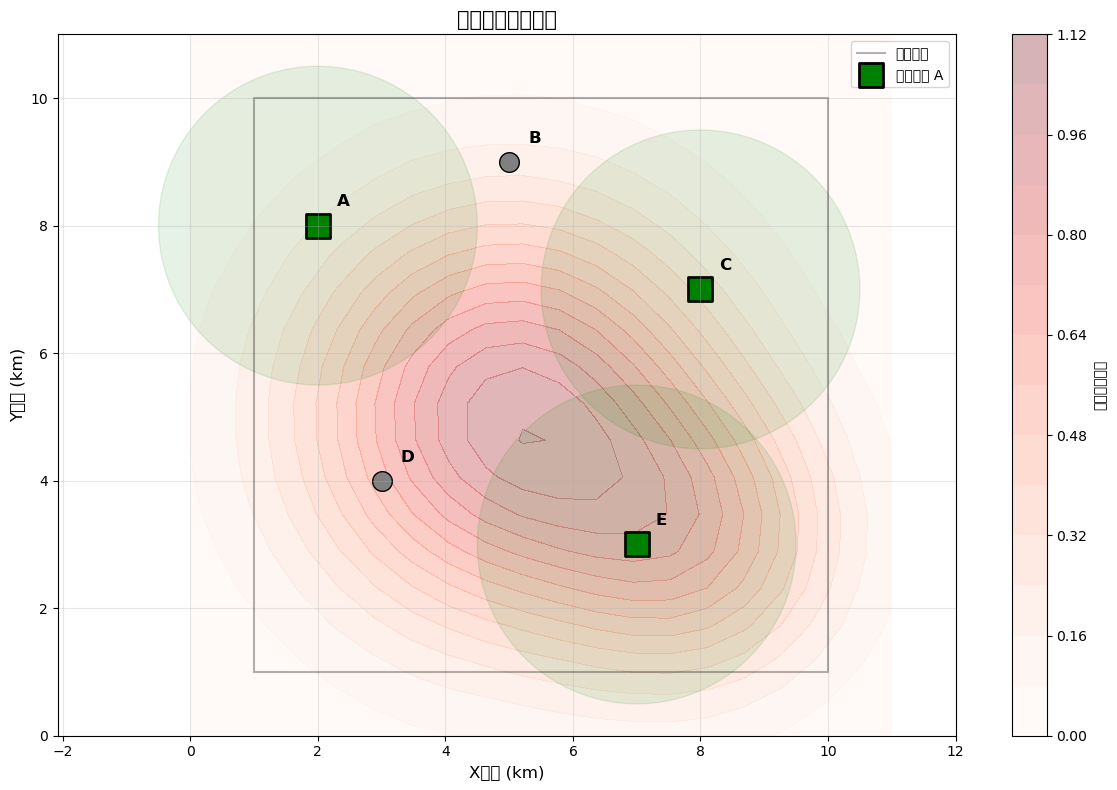

In [10]:
# 9. 可视化选址结果
plt.figure(figsize=(12, 8))

# 模拟位置坐标（实际应用中应使用真实地理坐标）
np.random.seed(42)
coords = {
    'A': (2, 8),
    'B': (5, 9),
    'C': (8, 7),
    'D': (3, 4),
    'E': (7, 3)
}

# 绘制城市区域（模拟）
city_x = [1, 1, 10, 10, 1]
city_y = [1, 10, 10, 1, 1]
plt.plot(city_x, city_y, 'k-', alpha=0.3, label='城市边界')

# 绘制人口密度（模拟）
x = np.linspace(0, 11, 20)
y = np.linspace(0, 11, 20)
X, Y = np.meshgrid(x, y)
Z = np.exp(-0.1*((X-5)**2 + (Y-5)**2)) + 0.5*np.exp(-0.2*((X-8)**2 + (Y-3)**2))
plt.contourf(X, Y, Z, 15, cmap='Reds', alpha=0.3)
plt.colorbar(label='相对人口密度')

# 绘制候选位置
for loc, (x, y) in coords.items():
    if loc in selected:
        plt.scatter(x, y, s=300, c='green', marker='s', edgecolor='black', linewidth=2, 
                   label=f'选定位置 {loc}' if loc == selected[0] else "")
        # 绘制覆盖范围
        circle = Circle((x, y), 2.5, color='green', alpha=0.1)
        plt.gca().add_patch(circle)
    else:
        plt.scatter(x, y, s=200, c='gray', marker='o', edgecolor='black', 
                   label='未选位置' if loc == 'A' else "")
        
# 添加标签
for loc, (x, y) in coords.items():
    plt.text(x+0.3, y+0.3, loc, fontsize=12, fontweight='bold')

plt.title('物流中心选址结果', fontsize=15)
plt.xlabel('X坐标 (km)', fontsize=12)
plt.ylabel('Y坐标 (km)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.axis('equal')
plt.tight_layout()
plt.show()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/73b59ebb2f7445ee81bb914c88639e5c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/73b59ebb2f7445ee81bb914c88639e5c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 45 RHS
At line 50 BOUNDS
At line 56 ENDATA
Problem MODEL has 4 rows, 5 columns and 20 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 125 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2

/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_18170/1630809170.py:45: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_18170/1630809170.py:45: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_18170/1630809170.py:45: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_18170/1630809170.py:45: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_18170/1630809170.py:45: UserWarning: Glyph 35206 (\N{CJK UNIFIED IDEOGRAPH-8986}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/b_/8gzz

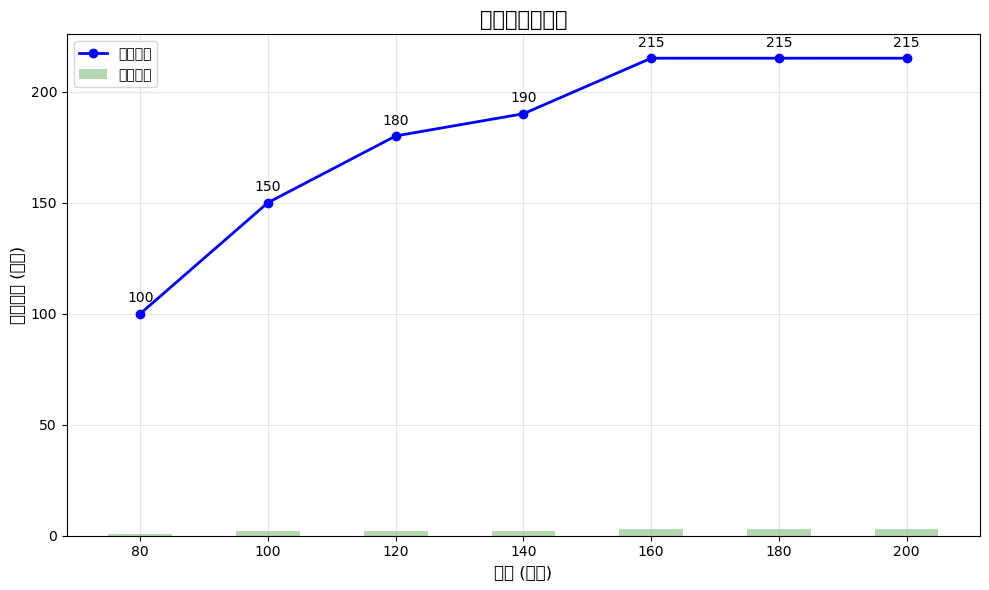


预算敏感性分析结果:
预算 =  80万元 | 最大覆盖人口 = 100千人 | 建设数量 = 1
预算 = 100万元 | 最大覆盖人口 = 150千人 | 建设数量 = 2
预算 = 120万元 | 最大覆盖人口 = 180千人 | 建设数量 = 2
预算 = 140万元 | 最大覆盖人口 = 190千人 | 建设数量 = 2
预算 = 160万元 | 最大覆盖人口 = 215千人 | 建设数量 = 3
预算 = 180万元 | 最大覆盖人口 = 215千人 | 建设数量 = 3
预算 = 200万元 | 最大覆盖人口 = 215千人 | 建设数量 = 3


In [11]:
# 10. 敏感性分析：预算变化的影响
budget_range = range(80, 201, 20)
max_populations = []
num_facilities = []

for b in budget_range:
    # 创建新问题
    prob_sens = pulp.LpProblem("Sensitivity_Analysis", pulp.LpMaximize)
    
    # 决策变量
    y_sens = pulp.LpVariable.dicts("Location", locations, cat=pulp.LpBinary)
    
    # 目标函数
    prob_sens += pulp.lpSum([populations[i] * y_sens[locations[i]] for i in range(len(locations))])
    
    # 约束
    prob_sens += pulp.lpSum([costs[i] * y_sens[locations[i]] for i in range(len(locations))]) <= b
    prob_sens += pulp.lpSum([emissions[i] * y_sens[locations[i]] for i in range(len(locations))]) <= max_emission
    prob_sens += pulp.lpSum(y_sens) >= min_facilities
    prob_sens += pulp.lpSum(y_sens) <= max_facilities
    
    # 求解
    prob_sens.solve(solver)
    
    # 记录结果
    max_populations.append(pulp.value(prob_sens.objective))
    num_facilities.append(sum(y_sens[loc].varValue for loc in locations))

# 绘制敏感性分析图
plt.figure(figsize=(10, 6))
plt.plot(budget_range, max_populations, 'bo-', linewidth=2, label='覆盖人口')
plt.bar(budget_range, num_facilities, width=10, alpha=0.3, color='green', label='建设数量')

plt.title('预算敏感性分析', fontsize=15)
plt.xlabel('预算 (万元)', fontsize=12)
plt.ylabel('覆盖人口 (千人)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# 添加数据标签
for i, (b, pop) in enumerate(zip(budget_range, max_populations)):
    plt.annotate(f'{int(pop)}', (b, pop+2), textcoords="offset points", 
                 xytext=(0,5), ha='center')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("预算敏感性分析结果:")
print("="*50)
for b, pop, num in zip(budget_range, max_populations, num_facilities):
    print(f"预算 = {b:3d}万元 | 最大覆盖人口 = {pop:3.0f}千人 | 建设数量 = {int(num)}")